# Workbench for analysis of the sinuosity of stream channels at Ghor Al-Haditha using shapefiles of channel centrelines digitised from high-resolution satellite imagery

**Robert A. Watson**\
Department of Earth Sciences, University College Dublin, Ireland\
*robert.watson@ucd.ie*

**Date**: 30.03.2020

## Import the data and setup the workspace and dataframes for subsequent analysis

In [1]:
from sinuutils import readshapestopandas

riverid = 6 # id of channel being analysed (CM_riverid)

channelname = '../sinuosity_shapefiles/sin_CM%d.shp' % riverid # define channel to be analysed
yearrivers = readshapestopandas(channelname)
# in yearrivers shapeid from readshapestopandas is the year that the profile was drawn

In [2]:
# import shapefile which contains the valley slopes aka meander belt axis for different years

valleyslope = '../sinuosity_shapefiles/valley_slope_prof_wgs84.shp'

direct_profiles = readshapestopandas(valleyslope)

# in this shapefile, the 'shapeid' is not a year but the id of the channel
# call the correct channel id using riverid

direct_profile = None
for shapeid, d in direct_profiles:
    if shapeid == riverid:
        direct_profile = d

dp_head = direct_profile.head() # see first 5 lines of dataframe 
print(dp_head);

         lat        lng           x           y     segleng          ar
0  31.316642  35.535948    0.000000    0.000000    0.000000    0.000000
1  31.318469  35.535669  -26.486694  203.335550  205.053385  205.053385
2  31.318990  35.534931  -96.670667  261.360416   91.064127  296.117512
3  31.320331  35.533295 -252.313884  410.617813  215.644572  511.762084
4  31.320270  35.532101 -365.853177  403.907083  113.737438  625.499523


## Plot profile for chosen channel in space relative to position of channel head

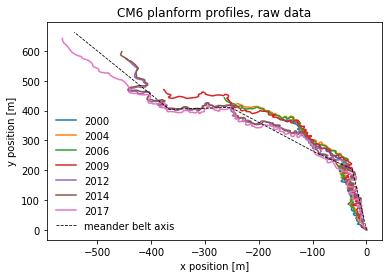

In [3]:
%matplotlib inline 
from matplotlib import pyplot as plt

for year, df in yearrivers:
    plt.plot(df.x, df.y, label='%d' % year)
    
plt.plot(direct_profile.x, direct_profile.y, color='k',linestyle='--',
         linewidth=0.8, label='meander belt axis')
plt.legend(loc='lower left',frameon=False)  
plt.title('CM%d planform profiles, raw data' % riverid)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]');

## Warp channel profile so that the meander belt axis behaves as the x-axis, meaning that sinuosity can be calculated relative to this only (simplifying code)

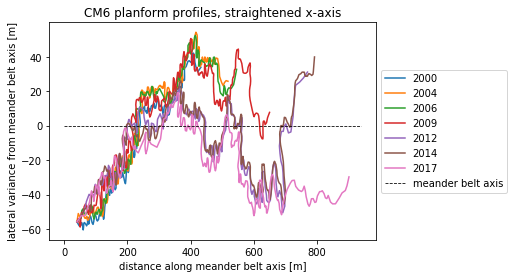

In [4]:
from sinuutils import transaxis
from sinuutils import warptodirect
import numpy as np

fig = plt.figure(figsize=(9,4))
ax = plt.subplot(111)
box = ax.get_position()
    
for year, df in yearrivers: # calculate straightened channel profiles
    straightenedx, straightenedy, cwtx, cwty, r0, r1 = warptodirect(direct_profile, df)
    ax.plot(straightenedx, straightenedy, label="%d" % year)
    
transax = np.linspace(0,r1,10)
transay = np.zeros((10,), dtype=int)

ax.plot(transax, transay, color='k', linestyle='--', linewidth=0.8, label="meander belt axis")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))

plt.title('CM%d planform profiles, straightened x-axis' % riverid)
plt.xlabel('distance along meander belt axis [m]')
plt.ylabel('lateral variance from meander belt axis [m]');

## Calculate windowed sinuosity of the river channel where windows are not regularised ie depend only on the length of each digitised centre-line segment in the shapefile

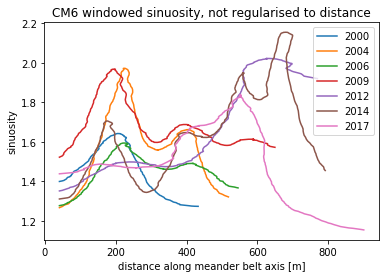

In [5]:
from sinuutils import windowed_sinuosity

# calculate windowed sinuosity for each given year
for year, df in yearrivers:
    wxs, awsin = windowed_sinuosity(df)
    plt.plot(df.straightenedx,df.windowedsin, label='%d' %year)

plt.title('CM%d windowed sinuosity, not regularised to distance' % riverid)
plt.xlabel('distance along meander belt axis [m]')
plt.ylabel('sinuosity')
plt.legend();

## Resample the channel profiles at metre-resolution so that distance along reach consistent in the channel profiles

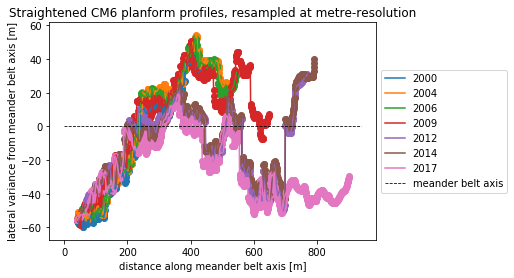

In [6]:
from sinuutils import metre_interp
import pandas as pd

fig = plt.figure(figsize=(9,4))
ax = plt.subplot(111)
box = ax.get_position()

yearrivers_interp = [ ]
for year, df in yearrivers:
    xvals, yinterp = metre_interp(df.straightenedx, df.straightenedy)
    df2 = pd.DataFrame({"chan_xvals":xvals, "chan_yinterp":yinterp})
    vx2 = (df2.chan_xvals - df2.chan_xvals.shift()).fillna(0)
    vy2 = (df2.chan_yinterp - df2.chan_yinterp.shift()).fillna(0)
    df2["straightenedsegleng"] = np.sqrt(vx2**2 + vy2**2)
    yearrivers_interp.append((year, df2))
     
    #plt.plot(df.straightenedx, df.straightenedy, label="%d" % year)
for year, df2 in yearrivers_interp:
    ax.plot(df2.chan_xvals, df2.chan_yinterp, label='%d' %year)
    ax.scatter(df2.chan_xvals, df2.chan_yinterp)
    
ax.plot(transax, transay, color='k', linestyle='--', linewidth=0.8, label="meander belt axis")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))

plt.title('Straightened CM%d planform profiles, resampled at metre-resolution' % riverid)
plt.xlabel('distance along meander belt axis [m]')
plt.ylabel('lateral variance from meander belt axis [m]');

In [7]:
yr_i = yearrivers_interp[:1]
print(yr_i); #example data for year 2000

[(2000,      chan_xvals  chan_yinterp  straightenedsegleng
0          41.0    -55.838104             0.000000
1          42.0    -56.159110             1.050259
2          43.0    -56.480115             1.050259
3          44.0    -56.801121             1.050259
4          45.0    -57.122126             1.050259
..          ...           ...                  ...
387       428.0     32.590521             1.035140
388       429.0     32.857944             1.035140
389       430.0     33.125368             1.035140
390       431.0     33.392791             1.035140
391       432.0     33.660215             1.035140

[392 rows x 3 columns])]


## Calculate windowed sinuosity of the river channel where window length can now be expressed in metres (absolute distance) rather than relative position of nodes

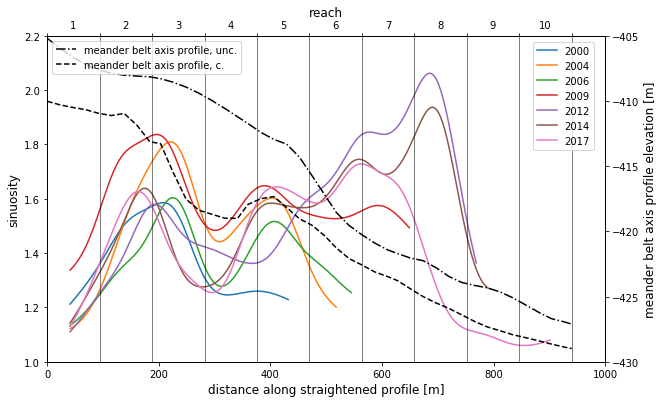

In [8]:
import matplotlib.ticker as ticker
from sinuutils import windowed_sin_interp
centreweightlength = 50 # width of window in metres: change as appropriate

fig = plt.figure(figsize = (10,6))
ax1 = plt.axes()

for year, df2 in yearrivers_interp:
    wxs, awsin = windowed_sin_interp(df2, centreweightlength)
    ax1.plot(df2.chan_xvals,df2.windowedsin, label='%d' %year)

ax1.set_xlim(0, 1000)
ax1.set_ylim(1, 2.2)
ax1.set_xlabel('distance along straightened profile [m]', fontsize=12)
ax1.set_ylabel('sinuosity', fontsize=12)

# read in meander belt axes profile

# dataframe for meander belt axis slopes
df3 = pd.read_csv('../sinuosity_shapefiles/corrected_bath_meander_belt_axes.csv', header=0)

for n in range(riverid,riverid+1): # get meander belt axis topography for specified channel id
    MBA = df3[df3.prof_id == n]

# plot channel reach as vertical guidelines    
reachx = np.linspace(0,MBA[-1:]['cds2d'],11)

for n in range (0, len(reachx)):
    ax1.axvline(x=reachx[n], color='k', linewidth=0.5)

# plot meander belt axis topography on right-hand y-axis
ax2 = ax1.twinx()

ax2.plot(MBA.cds2d, MBA.bathymetry, 'k-.', label='meander belt axis profile, unc.')
ax2.plot(MBA.cds2d, MBA.bathymetry_new, 'k--', label='meander belt axis profile, c.')

ax2.set_xlim(0, 1000)
ax2.set_ylim(-430, -405)
ax2.set_ylabel('meander belt axis profile elevation [m]', color='k', fontsize=12)
ax2.tick_params('y', colors='k')
ax1.legend(loc=[0.87, 0.65],fontsize=10)
ax2.legend(loc = 'upper left', fontsize=10)

# add reach to top x-axis 
ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.plot(range(1000), np.zeros(1000)) # Create a dummy plot
ax3.set_xlabel("reach", fontsize=12)

new_xtick_values = np.linspace(1,10,10)

# make the top x ticks integers, not floats
new_xtick_int = []

for each in new_xtick_values:
    new_xtick_int.append(int(each))

# plot reach values in centre of ticks
ax3.xaxis.set_major_locator(ticker.FixedLocator(reachx))

minor_tickloc = []
for val in reachx:
    minor_tickloc.append(val+(reachx[-1]/20))
    
ax3.xaxis.set_minor_locator(ticker.FixedLocator(minor_tickloc))


ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(new_xtick_int))

for tick in ax3.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center');

## Demonstrate the sensitivity of channel sinuosity to different window lengths

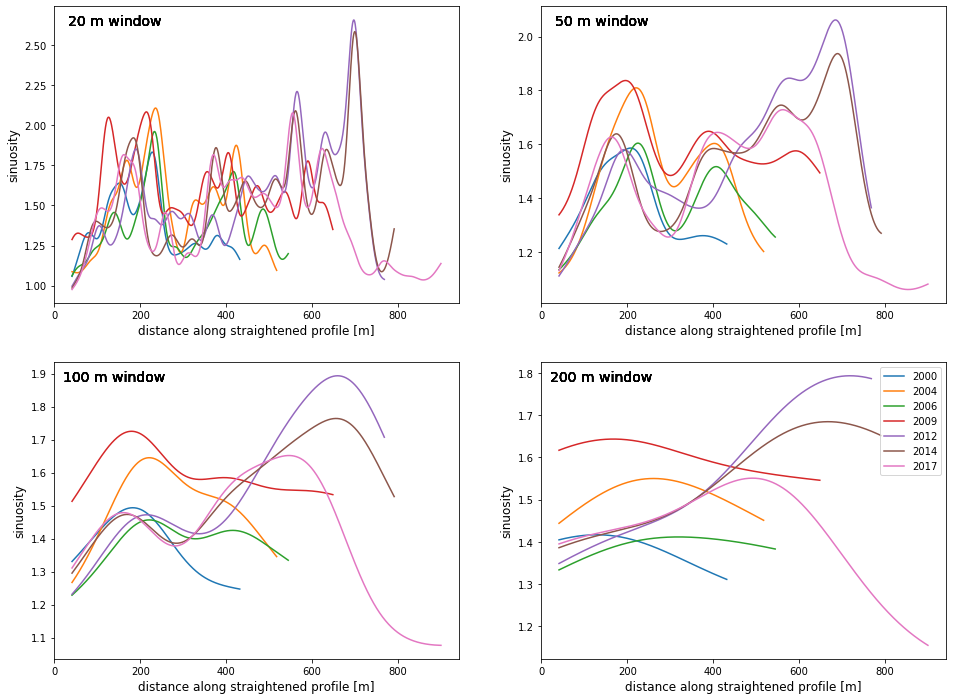

In [9]:
# plot channel sinuosity along length with different window lengths 

fig = plt.figure(figsize = (16,12))

window_tests = [20,50,100,200]

for n in range(0,4):
    ax = fig.add_subplot(2, 2, n+1)
    for year, df2 in yearrivers_interp:
        wxs, awsin = windowed_sin_interp(df2, window_tests[n])
        ax.plot(df2.chan_xvals,df2.windowedsin, label='%d' %year)
        ax.text(0.15, 0.95, '%d m window' %(window_tests[n]), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax.transAxes, fontsize=14)
        plt.xlabel('distance along straightened profile [m]', fontsize=12)
        plt.ylabel('sinuosity', fontsize=12)

plt.legend(loc = 'upper right');